# Exploratory Analysis of Global Volumetric MRI Features

This notebook performs an exploratory data analysis (EDA) of global volumetric descriptors extracted from preprocessed 3D MRI scans from the OASIS dataset.

Patient-level metadata and volumetric features are queried from a relational SQLite database to enable reproducible and systematic analysis.

This notebook can be run only after data has been preprocessed at least once. Run the preprocess.py script in /src or the full train_evaluate.py program


# Imports

In [6]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Move to project folder and set paths

In [19]:
# Are we running this notebook in colab?
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Personal colab project folder
COLAB_ROOT = Path("/content/drive/MyDrive/Progetti/alzheimer_mri_cnn")

# Ensure working directory is project root
if Path.cwd().parent.name == "alzheimer_mri_cnn":
  os.chdir(Path.cwd().parent)
elif IN_COLAB:
  os.chdir(COLAB_ROOT)
elif Path.cwd().name == "alzheimer_mri_cnn":
  pass
else:
  raise RuntimeError("Project root not found")

print("Working directory set to:", Path.cwd())

# Paths
DB_PATH = Path("./data/processed/oasis.db")
FIGURES_DIR = Path("./outputs/notebooks_figs")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
plt.rcParams["figure.dpi"] = 120


Working directory set to: /content/drive/MyDrive/Progetti/alzheimer_mri_cnn


# Database connection and SQL query

In [20]:
conn = sqlite3.connect(DB_PATH)

query = """
SELECT
    p.patient_id,
    p.label,
    v.mean,
    v.std,
    v.entropy,
    v.min,
    v.max,
    v.p1,
    v.p99
FROM patients p
JOIN volumes v USING(patient_id)
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.head()


,patient_id,label,mean,std,entropy,min,max,p1,p99
0,OAS1_0001_MR1,0,-1.098961e-07,1.000000,2.422619,-2.080262,7.005158,-0.533944,4.022673
1,OAS1_0002_MR1,0,7.450581e-09,1.000000,2.180337,-1.293157,7.113133,-0.494779,4.101749
2,OAS1_0010_MR1,0,2.374873e-08,1.000001,2.534289,-1.994173,6.774091,-0.573939,3.827393
3,OAS1_0011_MR1,0,-3.026798e-08,1.000000,2.323573,-1.074979,7.499508,-0.504325,4.208089
4,OAS1_0013_MR1,0,-1.676381e-08,1.000000,2.589648,-1.630996,7.015373,-0.567108,3.635589


# Dataset check

In [21]:
df.info()
df["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  34 non-null     object 
 1   label       34 non-null     int64  
 2   mean        34 non-null     float64
 3   std         34 non-null     float64
 4   entropy     34 non-null     float64
 5   min         34 non-null     float64
 6   max         34 non-null     float64
 7   p1          34 non-null     float64
 8   p99         34 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.5+ KB


,count
label,
0,26
1,8


# Group stats

In [22]:
features = [
    "mean",
    "std",
    "entropy",
    "min",
    "max",
    "p1",
    "p99"
]

group_stats = df.groupby("label")[features].agg(["mean", "std"])
group_stats

mean                std                 entropy            \
               mean           std mean           std      mean       std   
label                                                                      
0     -1.038783e-09  1.127278e-07  1.0  4.763383e-07  2.420291  0.114554   
1      8.553616e-08  1.159104e-07  1.0  5.396842e-07  2.512564  0.336969   

            min                 max                  p1                 p99  \
           mean       std      mean       std      mean       std      mean   
label                                                                         
0     -1.512826  0.365302  7.264715  0.632467 -0.543413  0.033414  3.825346   
1     -1.774033  0.349511  6.785852  0.603498 -0.549220  0.056178  4.033758   

                 
            std  
label            
0      0.291185  
1      0.212004

# Global mean intensity boxplot

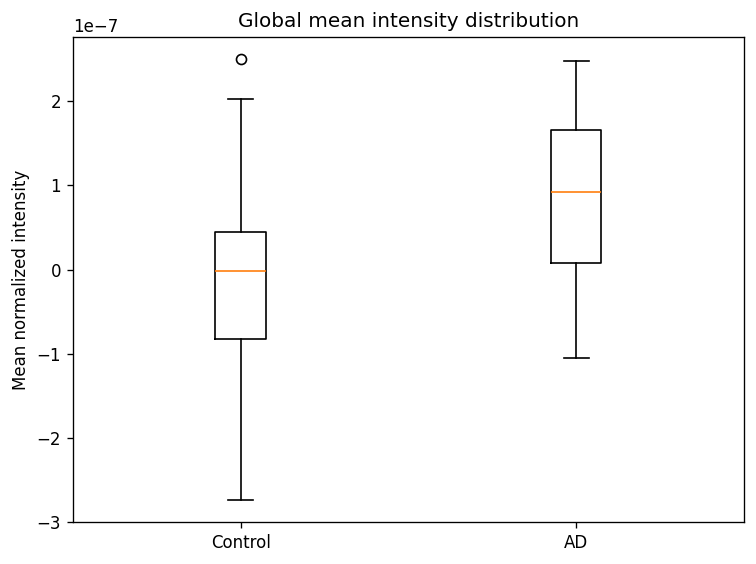

In [23]:
ctrl = df[df.label == 0]["mean"]
ad = df[df.label == 1]["mean"]

plt.figure()
plt.boxplot([ctrl, ad], tick_labels=["Control", "AD"])
plt.ylabel("Mean normalized intensity")
plt.title("Global mean intensity distribution")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "mean_intensity_boxplot.png")
plt.show()


# Global STD boxplot

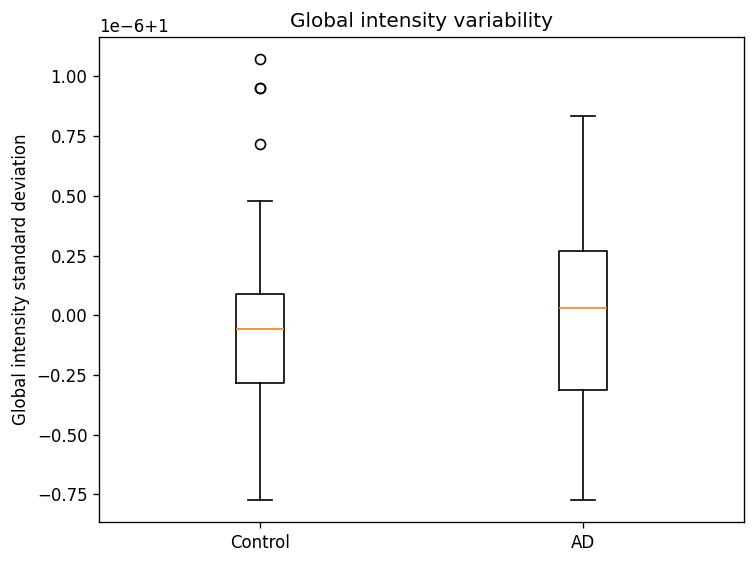

In [24]:
ctrl_std = df[df.label == 0]["std"]
ad_std = df[df.label == 1]["std"]

plt.figure()
plt.boxplot([ctrl_std, ad_std], tick_labels=["Control", "AD"])
plt.ylabel("Global intensity standard deviation")
plt.title("Global intensity variability")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "std_intensity_boxplot.png")
plt.show()


# Volume entropy boxplot

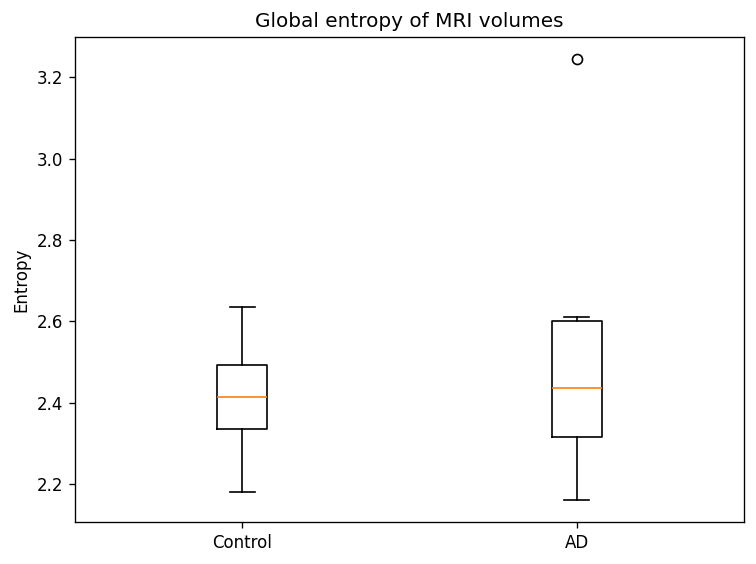

In [25]:
ctrl_ent = df[df.label == 0]["entropy"]
ad_ent = df[df.label == 1]["entropy"]

plt.figure()
plt.boxplot([ctrl_ent, ad_ent], tick_labels=["Control", "AD"])
plt.ylabel("Entropy")
plt.title("Global entropy of MRI volumes")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "entropy_boxplot.png")
plt.show()


# Mean vs STD scatter plot

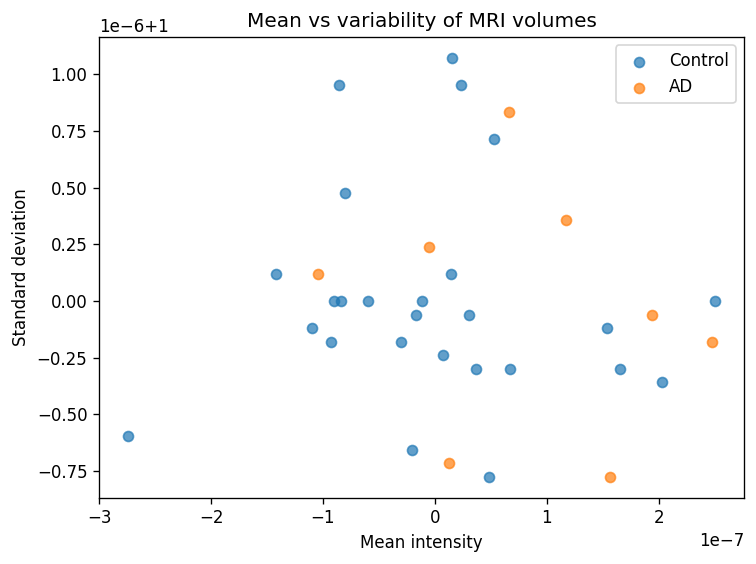

In [26]:
plt.figure()
plt.scatter(
    df[df.label == 0]["mean"],
    df[df.label == 0]["std"],
    label="Control",
    alpha=0.7
)
plt.scatter(
    df[df.label == 1]["mean"],
    df[df.label == 1]["std"],
    label="AD",
    alpha=0.7
)

plt.xlabel("Mean intensity")
plt.ylabel("Standard deviation")
plt.legend()
plt.title("Mean vs variability of MRI volumes")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "mean_vs_std_scatter.png")
plt.show()
